In [1]:
import tensorflow as tf
tf.__version__

#tensorflow 버젼 확인

'2.13.0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#구글 드라이브 연결

Mounted at /content/gdrive


In [3]:
!pip install kaggle
# kaggle api 설치

In [4]:
from google.colab import files
files.upload()
#kaggle에 가입해서 로그인 한 후 우측 상단에 오리 아이콘 클릭해서 APi Token 생성 후 kaggle.json 다운받기
#kaggle.json kaggle 홈페이지에서 다운 받아서 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kwonohjin","key":"0a0b978547d832a6b0b3b5d9d88380af"}'}

In [5]:
!ls -1ha kaggle.json
#파일 업로드 확인

kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
#kaggle API가 Token 사용하게 하기 위해 kaggle.json 파일을 이동

In [7]:
!chmod 600 ~/.kaggle/kaggle.json
#permission Warning 일어나지 않도록 권한 부여

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# 흉부 x-ray 다운받기위해 https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia url 접속
# 캐글 홈페이지에서 Copy API command 선택하여 데이터셋 다운

100% 2.29G/2.29G [01:45<00:00, 21.8MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.4MB/s]


In [9]:
from zipfile import ZipFile
with ZipFile('chest-xray-pneumonia.zip') as z:
  z.extractall()
#다운받은 zip 파일 압축 해제

In [10]:
!rm chest-xray-pneumonia.zip
#불필요한 파일 제거

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import matplotlib.image as mpimg
#패키지와 모듈 불러오기

In [12]:
total_images_train_normal = os.listdir('/content/chest_xray/chest_xray/train/NORMAL')
total_images_train_pneumonia = os.listdir('/content/chest_xray/chest_xray/train/PNEUMONIA')
#train set 에서 정상적인 사람과 폐렴에 걸린 사람의 폐 사진 불러오기 (자기 경로에 맞게 설정해야함)

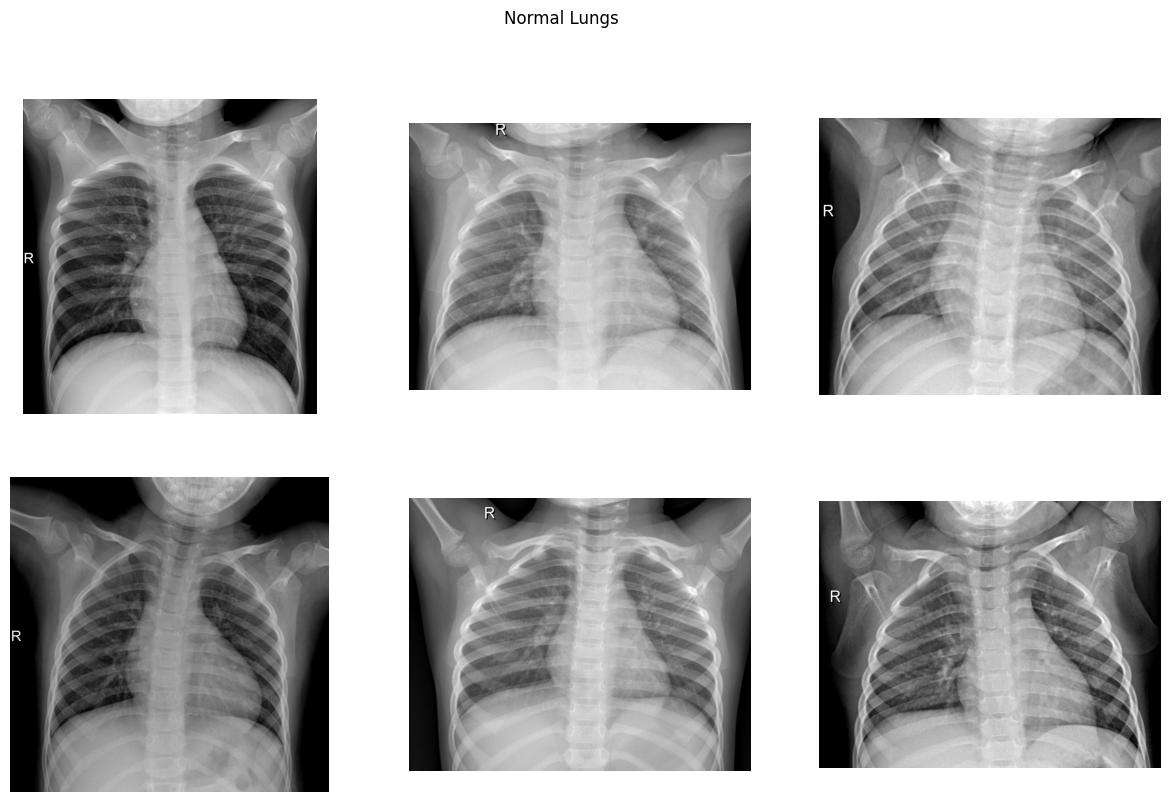

In [13]:
import cv2
import random
import matplotlib.pyplot as plt

sample_normal = random.sample(total_images_train_normal, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(0, 6):
    im = cv2.imread('/content/chest_xray/chest_xray/train/NORMAL/' + sample_normal[i])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # BGR을 RGB로 변환
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')

f.suptitle('Normal Lungs')
plt.show()
#정상적인 폐사진 보여주기

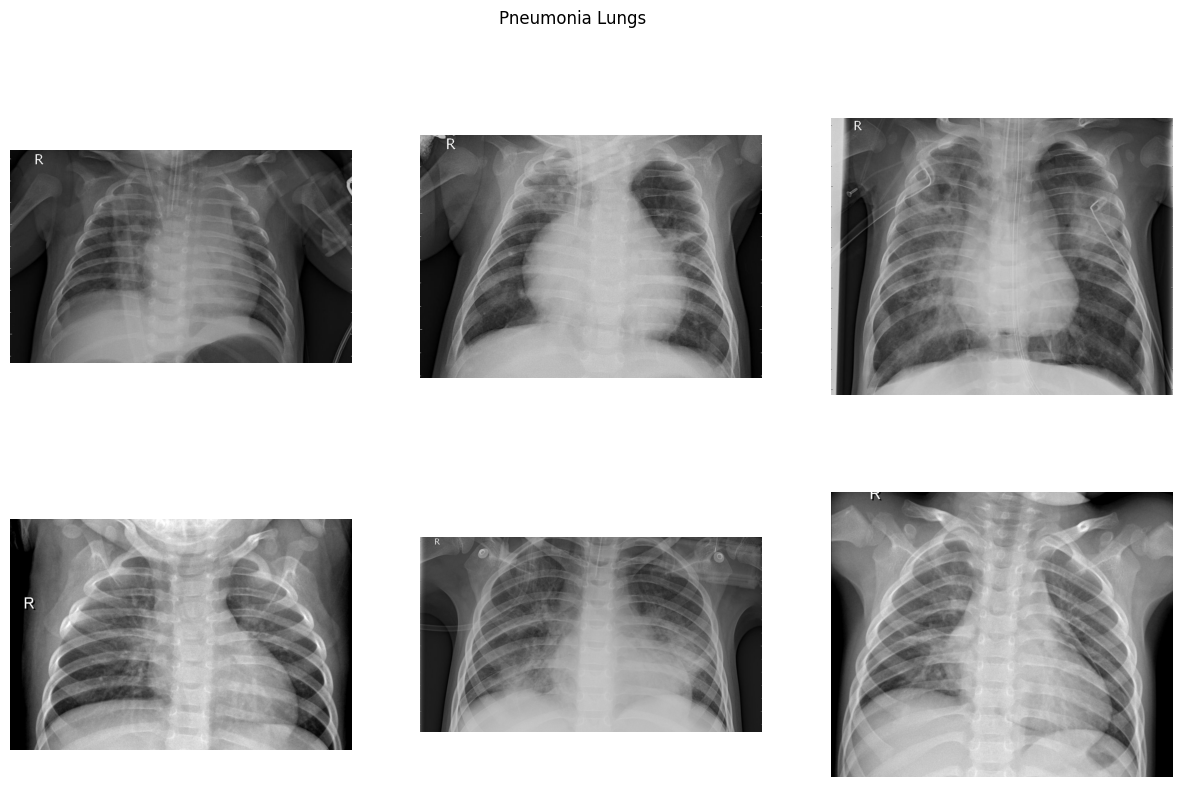

In [14]:
sample_pneumonia = random.sample(total_images_train_pneumonia, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(0, 6):
    im = cv2.imread('/content/chest_xray/chest_xray/train/PNEUMONIA/' + sample_pneumonia[i])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # BGR을 RGB로 변환
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')

f.suptitle('Pneumonia Lungs')
plt.show()

#폐렴에 걸린 사람의 폐사진 샘플 보여주기

In [15]:
image_height = 150
image_width = 150
batch_size = 10
no_of_epochs = 30

#필요한 상수들 정의

In [16]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#이미지 분류를 위한 모델 생성

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)

# imageDataGenerator 클래스를 통해 train_datagen 인스턴트 생성
# imageDataGenerator 클래스를 통해 val_datagen 인스턴트 생성

In [18]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/chest_xray/train',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

# train_datagen 인스턴트를 통해 train dataset에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체 생성

Found 5216 images belonging to 2 classes.


In [19]:
test_set = val_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

# val_datagen 인스턴트를 통해 train dataset에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체 생성

Found 624 images belonging to 2 classes.


In [20]:
val_set = val_datagen.flow_from_directory('/content/chest_xray/chest_xray/val',target_size=(image_width, image_height),batch_size=1,shuffle=False,class_mode='binary')

# val_datagen 인스턴트를 통해 val dataset에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체 생성

Found 16 images belonging to 2 classes.


In [21]:
modelCheckpoint = ModelCheckpoint('diagnose_pneumonia_model.h5',save_best_only=True)

# 모델 학습시 가장 최신의 최고 모델을 저장하는 옵션을 정의

In [22]:
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

#모델 학습시 정확도를 모니터링하여 조기에 학습 종료

In [23]:
history = model.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=[monitor_val_acc, modelCheckpoint]
                   )
# 모델 학습


Epoch 1/30
521/521 [==============================] - 102s 171ms/step - loss: 0.4997 - accuracy: 0.7689 - val_loss: 0.4912 - val_accuracy: 0.7645
Epoch 2/30
521/521 [==============================] - 85s 163ms/step - loss: 0.3096 - accuracy: 0.8617 - val_loss: 0.4644 - val_accuracy: 0.8210
Epoch 3/30
521/521 [==============================] - 84s 162ms/step - loss: 0.2735 - accuracy: 0.8907 - val_loss: 0.3731 - val_accuracy: 0.8177
Epoch 4/30
521/521 [==============================] - 86s 165ms/step - loss: 0.2620 - accuracy: 0.8944 - val_loss: 0.4066 - val_accuracy: 0.8403
Epoch 5/30
521/521 [==============================] - 84s 161ms/step - loss: 0.2363 - accuracy: 0.9055 - val_loss: 0.7026 - val_accuracy: 0.7145
Epoch 6/30
521/521 [==============================] - 85s 162ms/step - loss: 0.2352 - accuracy: 0.9047 - val_loss: 0.3312 - val_accuracy: 0.8645
Epoch 7/30
521/521 [==============================] - 84s 162ms/step - loss: 0.2276 - accuracy: 0.9061 - val_loss: 0.3579 - val_a

In [25]:
score = model.evaluate(test_set, steps=624/batch_size, verbose=1)
print('Val loss:', score[0])
print('Val accuracy:', score[1]*100)

#만든 모델 평가

62/62 [==============================] - 7s 107ms/step - loss: 0.4173 - accuracy: 0.8638
Val loss: 0.4172936975955963
Val accuracy: 86.37820482254028


In [26]:
print(test_set.class_indices)

# test_set이 만들어 내는 이미지 클래스 인덱스 확인

{'NORMAL': 0, 'PNEUMONIA': 1}


In [27]:
plt.figure(figsize=(16,5))


<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

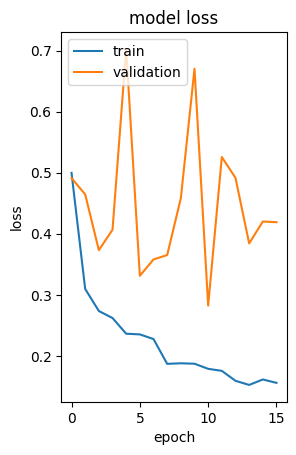

In [30]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')

#loss 그래프 표현

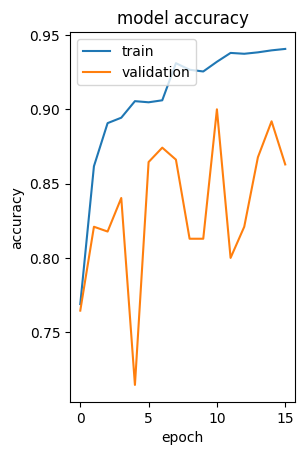

In [31]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')

#accuracy 그래프로 표현

In [32]:
predictions = model.predict(val_set, steps=16, verbose=1)

#만든 모델을 분류 예측

16/16 [==============================] - 1s 9ms/step


In [33]:
print(val_set.class_indices)

#val_set에서 만들어내는 이미지의 클래스 인덱스 확인

{'NORMAL': 0, 'PNEUMONIA': 1}


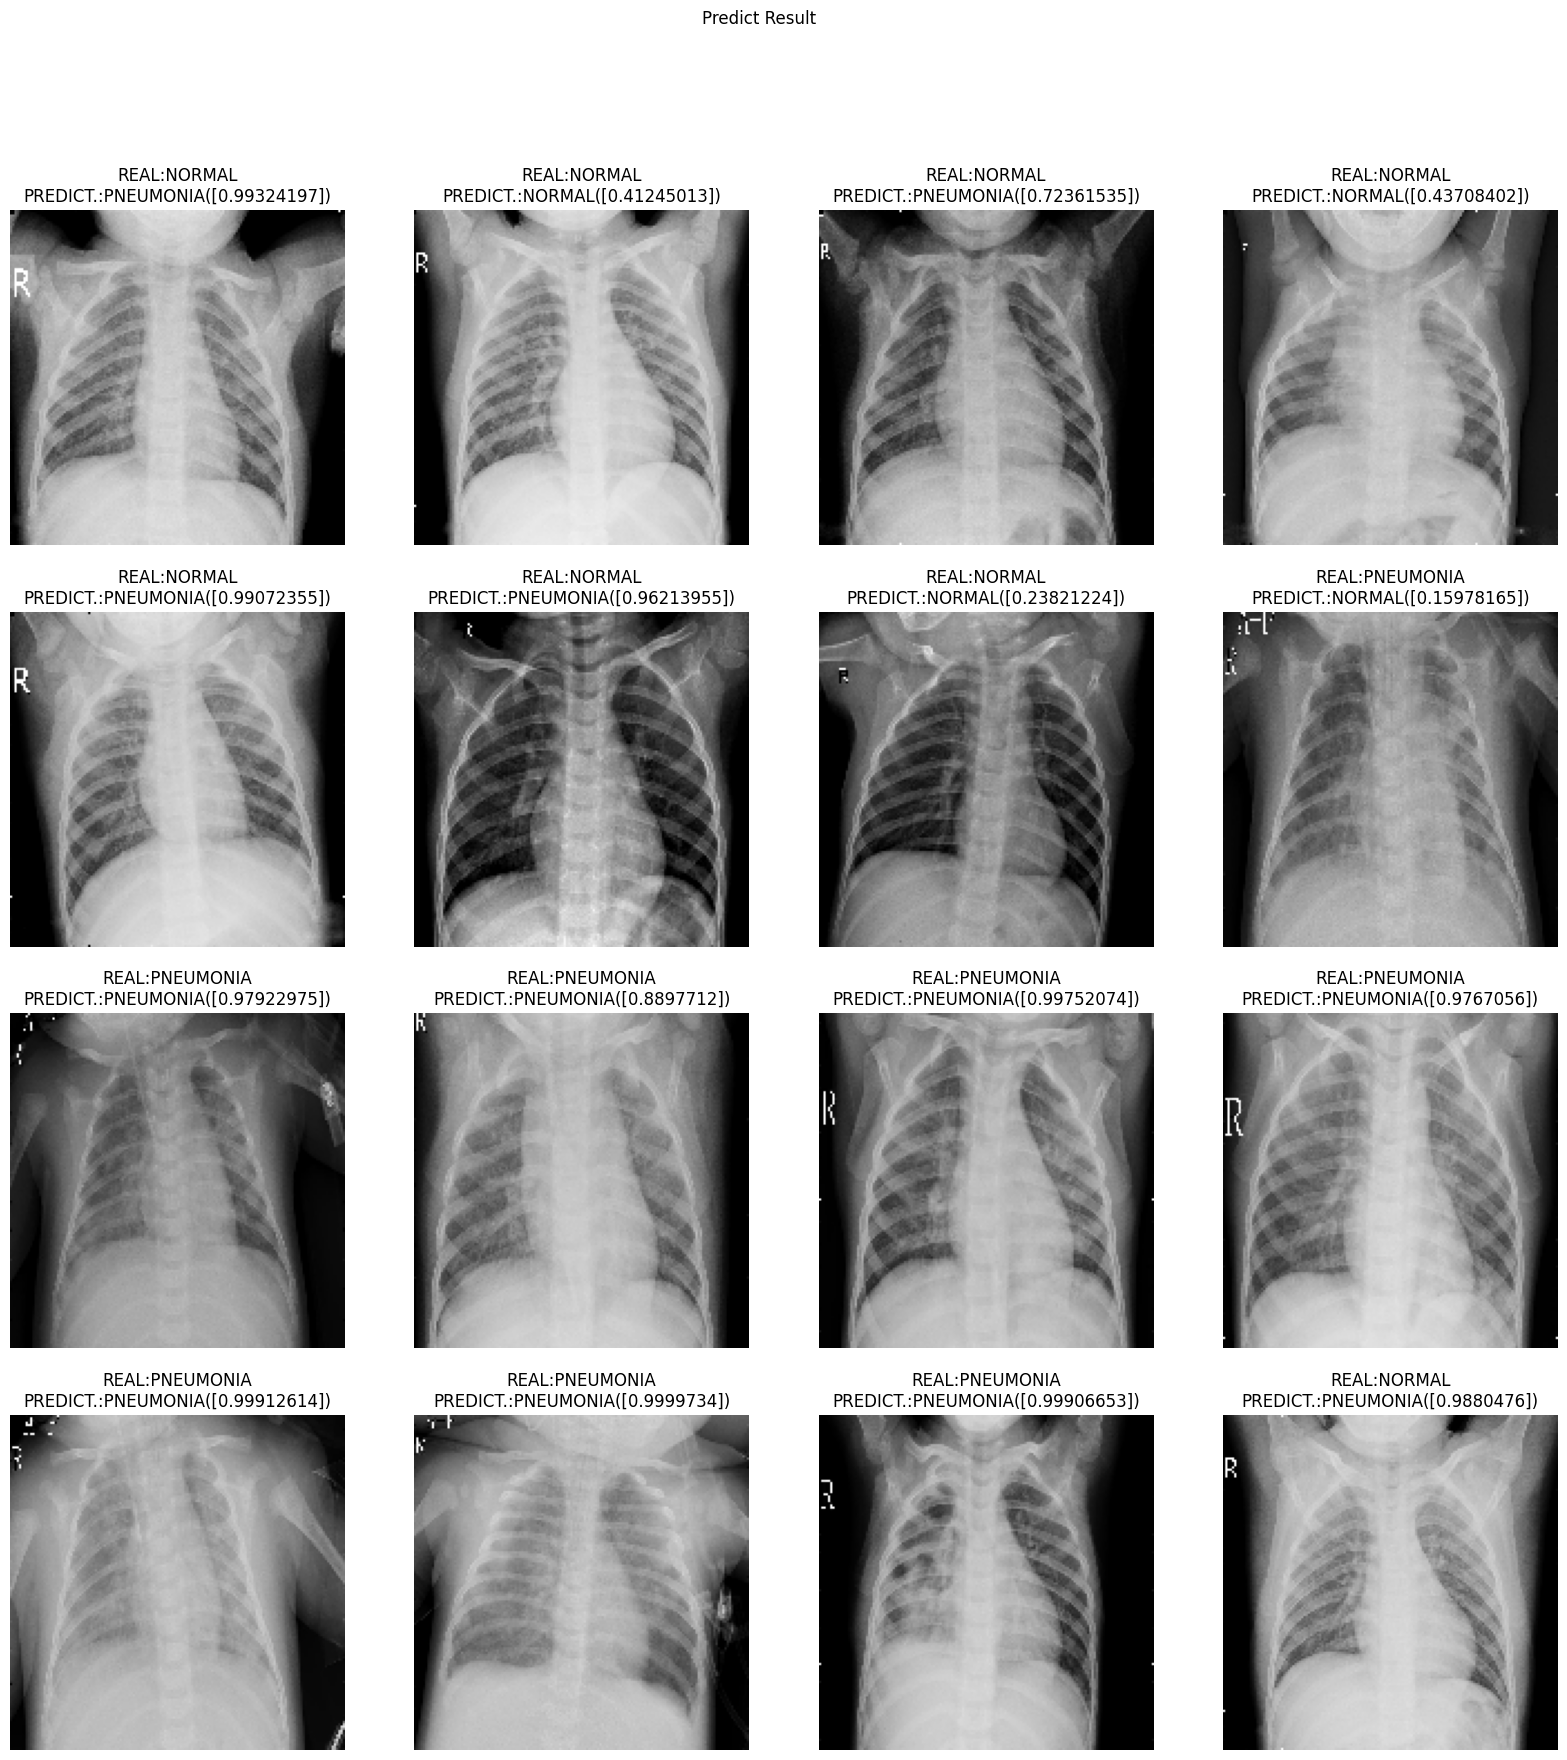

In [37]:
f,ax = plt.subplots(4,4,figsize=(20,20))

for i in range(len(predictions)):
  image, label = val_set.next()
  real_class = 'NORMAL' if int(label) == 0 else 'PNEUMONIA'
  ax[i//4,i%4].imshow(image[0])
  ax[i//4,i%4].axis('off')

  pred_class = 'PNEUMONIA' if predictions[i] > 0.5 else 'NORMAL'
  pred_prob = predictions[i]
  ax[i//4,i%4].set_title('REAL:'+real_class+'\nPREDICT.:'+pred_class+'(' + str(pred_prob)+')')

f.suptitle('Predict Result')
plt.show()

#val_set가 만들어낸 이미지를 우리가 만든 모델을 통해 예측한 결과 보여줌